In [37]:
#Manejo de datos
import pandas as pd
import numpy as np

#Preprocesamiento de entrenamiento y prueba
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score

# Para menejo de PLN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords

#Modelado y metricas
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

#Gráficas
import matplotlib.pyplot as plt

#Quitar avisos molestos
import warnings
from sklearn.exceptions import FitFailedWarning

# Ignorar ciertas advertencias
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*') 

In [14]:
#Leer la base de datos
df = pd.read_excel("textos.xlsx")

In [15]:
#Recordar que el estado es para determinar el documento de interés y la cominidad es la clasificación de
#los documentos de interés
df.columns

Index(['N.', 'ARCHIVO', 'TEXTO', 'ESTADO', 'COMUNIDAD'], dtype='object')

In [4]:
#Descargar los stop words convencionales de nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57350\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#Definir una función que reprocese los textos
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('spanish'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [16]:
#Se guardan los textos reprocesados
df['TEXTO2'] = df['TEXTO'].apply(preprocess_text)

In [17]:
#Se filtran los documentos de interés
df = df[df["ESTADO"]==1]

In [18]:
#Se definen conjuntos de entrenamiento y prueba
y = df['COMUNIDAD']
X_train, X_test, y_train, y_test = train_test_split(df['TEXTO2'], y, test_size=0.33, random_state=53)

In [13]:
#0 = NEGRA -AFRO- RAIZAL-PALENQUERA
#1 = INDIGENA

In [20]:
# Vectorización con CountVectorizer
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [21]:
# Definición de parámetros para GridSearchCV
param_grid_nb = {'alpha': [0.01, 0.1, 1, 10],'fit_prior': [True, False]}
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_rf = {'n_estimators': [100, 200], 'max_features': ['sqrt', 'log2']}
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.5]}

# Configuración de GridSearchCV para cada modelo
models_params = {
    
    ('Logistic Regression', LogisticRegression(solver='liblinear')): param_grid_lr,
    ('Multinomial Naive Bayes', MultinomialNB()): param_grid_nb,
    ('SVM', SVC()): param_grid_svc,
    ('Random Forest', RandomForestClassifier()): param_grid_rf,
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')): param_grid_xgb
}

# Ejecución de GridSearchCV para cada modelo y recolección de datos
train_scores = []
test_scores = []
models = []
best_estimators={}


for (name, model), params in models_params.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(count_train, y_train)
    models.append(name)
    train_scores.append(grid_search.cv_results_['mean_test_score'])
    best_estimators[name] = grid_search.best_estimator_
    test_score = best_estimators[name].score(count_test, y_test)
    test_scores.append(test_score)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_}")
    print(f"Test score for {name}: {test_score}")

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation score for Logistic Regression: 1.0
Test score for Logistic Regression: 1.0
Best parameters for Multinomial Naive Bayes: {'alpha': 10, 'fit_prior': True}
Best cross-validation score for Multinomial Naive Bayes: 1.0
Test score for Multinomial Naive Bayes: 1.0
Best parameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score for SVM: 0.9925
Test score for SVM: 0.9848484848484849
Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.99
Test score for Random Forest: 0.98989898989899
Best parameters for XGBoost: {'learning_rate': 0.01, 'n_estimators': 100}
Best cross-validation score for XGBoost: 0.9949999999999999
Test score for XGBoost: 0.9949494949494949


In [23]:
best_estimators

{'Logistic Regression': LogisticRegression(C=0.01, solver='liblinear'),
 'Multinomial Naive Bayes': MultinomialNB(alpha=10),
 'SVM': SVC(C=0.1, kernel='linear'),
 'Random Forest': RandomForestClassifier(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None, ...)}

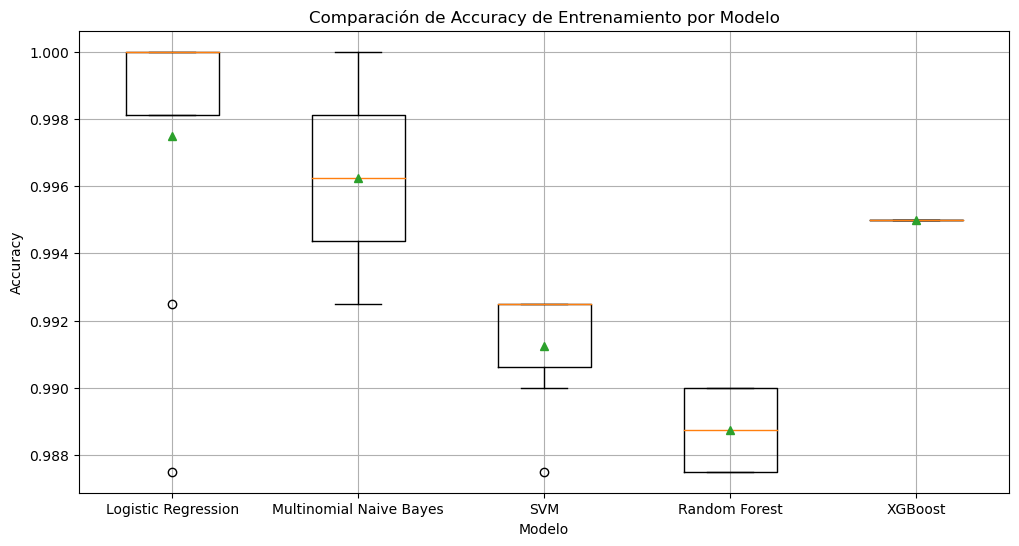

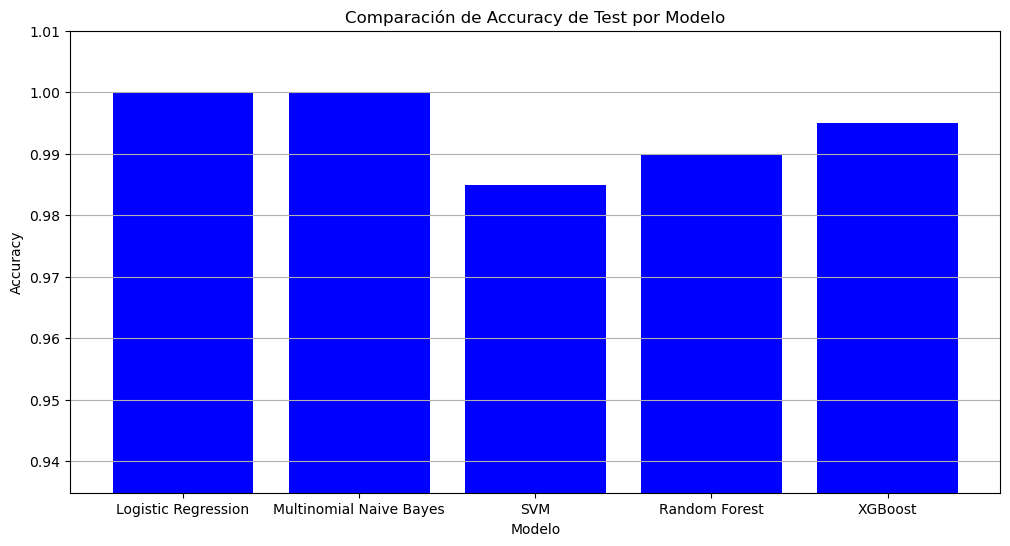

In [22]:
# Gráfico de cajas para ACC de entrenamiento
plt.figure(figsize=(12, 6))
plt.boxplot(train_scores, labels=models, showmeans=True)
plt.title('Comparación de Accuracy de Entrenamiento por Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.grid(True)
plt.show()

# Gráfico de barras para ACC de test
plt.figure(figsize=(12, 6))
plt.bar(models, test_scores, color='blue')
plt.title('Comparación de Accuracy de Test por Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.ylim([min(test_scores) - 0.05, max(test_scores) + 0.01])  # Ajustar límites para mejor visualización
plt.grid(True, axis='y')
plt.show()

In [ ]:
test_score_xgb = best_estimators["XGBoost"].predict(count_test)

In [38]:
# Esto es un reciclaje de una proyecto anterior
# def metricas (y_test, X_test,modelo, umbral):
#     # Obtener las probabilidades de pertenecer a cada clase
#     y_pred_prob = modelo.predict_proba(X_test)[:, 1]
#     # Ajustar el umbral
#     threshold = umbral
#     # Asignar las clases según el umbral
#     y_pred = np.where(y_pred_prob > threshold, 1, 0)
#     # Matriz de confusión
#     cm_over = confusion_matrix(y_test, y_pred)
#     f, ax = plt.subplots(figsize =(5,5))
#     sns.heatmap(cm_over, annot =True, linewidths = 0.5, linecolor ="black",fmt = ".0f", ax = ax)
#     plt.xlabel("Predicho")
#     plt.ylabel("Observado")
#     plt.show()
#     # Resumen
#     print(classification_report(y_test, y_pred))
#     # Curva ROC
#     fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
#     auc = metrics.roc_auc_score(y_test, y_pred_prob)
#     plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
#     plt.legend(loc=4)
#     plt.show()

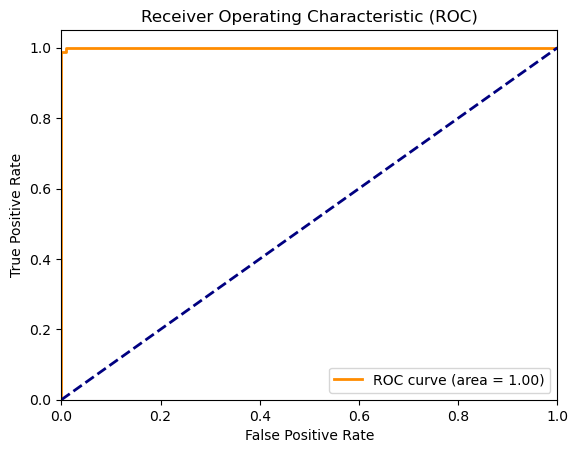

Matriz de confusión:
[[121   0]
 [  0  77]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       121
         1.0       1.00      1.00      1.00        77

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198



In [45]:
#Observamos medidas de desempeño en la clasificación
y_pred_proba = best_estimators["XGBoost"].predict_proba(count_test)[:, 1] 

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)



# Matriz de confusión
y_pred = best_estimators["Logistic Regression"].predict(count_test)
conf_matrix = confusion_matrix(y_test, y_pred)


classification_rep = classification_report(y_test, y_pred)

# Visualización de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Visualización de la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print(classification_rep)


In [ ]:
#No imprimo el df con la predicción en un excel para comparar manual, la precisión y el ACC es del 100%